# selecting light-sheet fluorescence microscopy pixels for analysis

## loading data

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time
import seaborn

data_path = '../fits/lsfm/grid_quick/'
y_vars = np.load(data_path + 'y_vars.npy')
y_means = np.load(data_path + 'y_means.npy') # using variance only for now

## pixel set selection

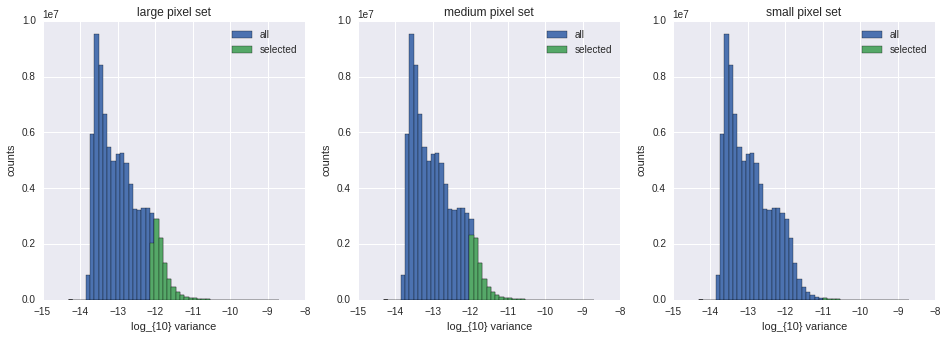

large idx set size  10430256
medium idx set size  7828017
small idx set size  160495


In [2]:
bins = np.linspace(np.log10(y_vars.min()), np.log10(y_vars.max()), 50)

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
idx_large = np.where(y_vars.reshape(-1) > 8 * 1e-13)[0]
plt.hist(np.log10(y_vars.reshape(-1)), bins=bins)
plt.hold(True)
plt.hist(np.log10(y_vars.reshape(-1)[idx_large]), bins=bins)
plt.xlabel('log_{10} variance')
plt.ylabel('counts')
plt.legend(('all', 'selected'))
plt.title('large pixel set')

plt.subplot(1,3,2)
idx_medium = np.where(y_vars.reshape(-1) > 1e-12)[0]
plt.hist(np.log10(y_vars.reshape(-1)), bins=bins)
plt.hold(True)
plt.hist(np.log10(y_vars.reshape(-1)[idx_medium]), bins=bins)
plt.xlabel('log_{10} variance')
plt.ylabel('counts')
plt.legend(('all', 'selected'))
plt.title('medium pixel set')

plt.subplot(1,3,3)
idx_small = np.where(y_vars.reshape(-1) > 1e-11)[0]
plt.hist(np.log10(y_vars.reshape(-1)), bins=bins)
plt.hold(True)
plt.hist(np.log10(y_vars.reshape(-1)[idx_small]), bins=bins)
plt.xlabel('log_{10} variance')
plt.ylabel('counts')
plt.legend(('all', 'selected'))
plt.title('small pixel set')
plt.show()

print('large idx set size ', len(idx_large))
print('medium idx set size ', len(idx_medium))
print('small idx set size ', len(idx_small))



## locating selected pixels within the image stack

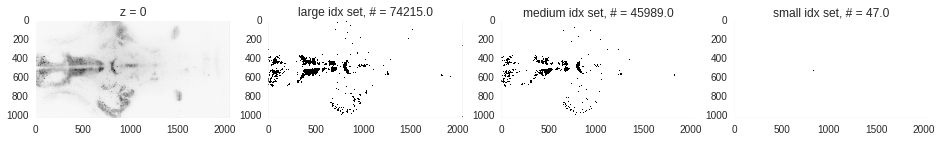

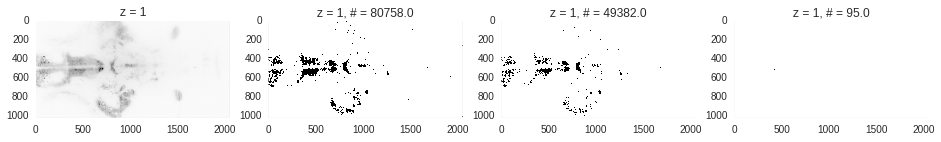

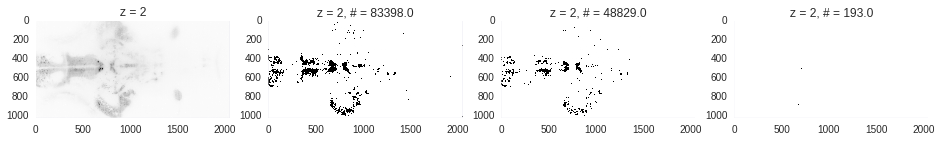

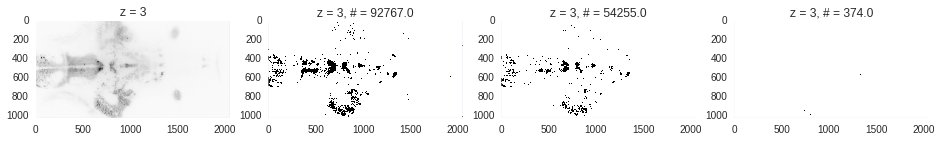

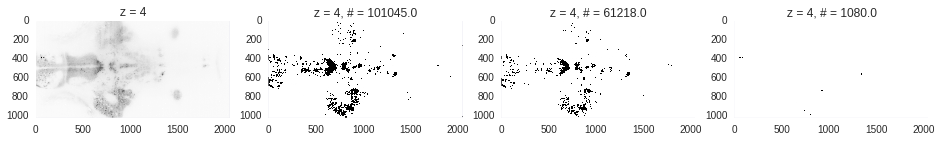

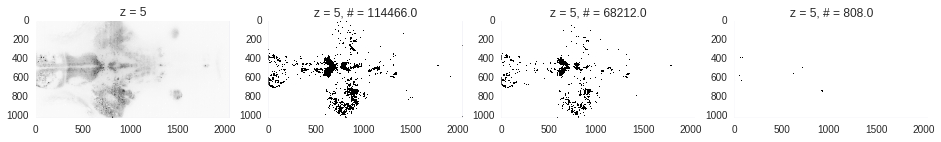

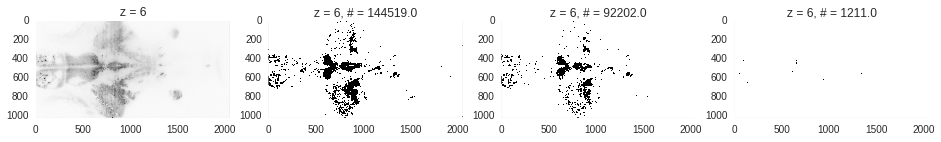

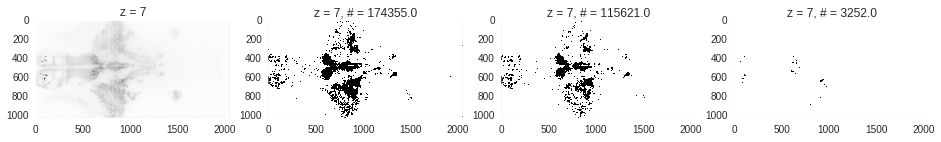

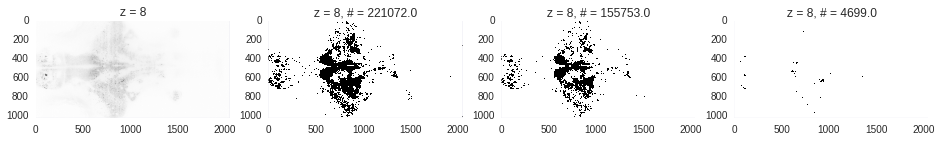

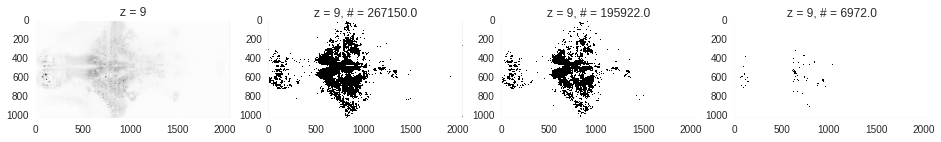

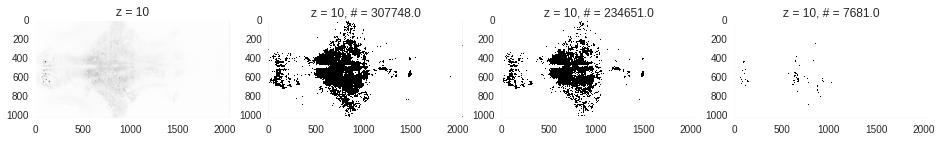

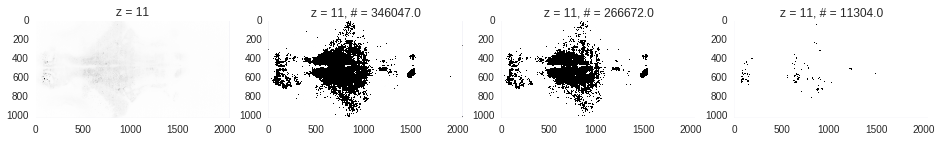

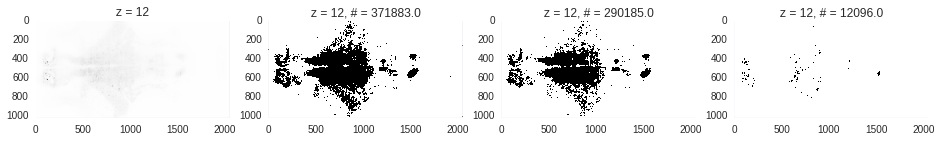

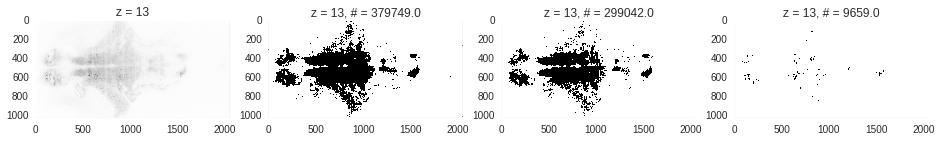

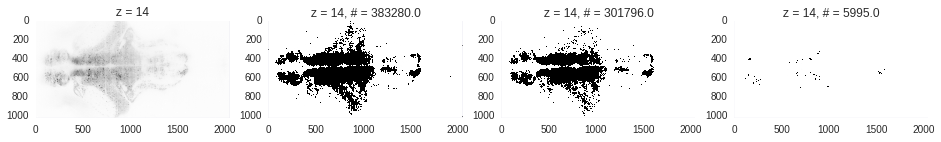

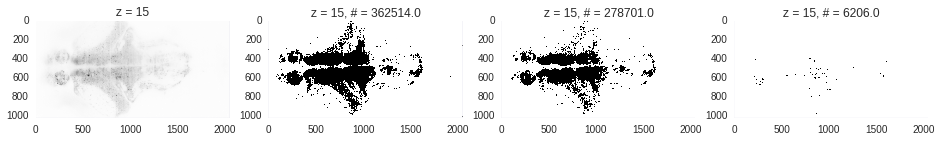

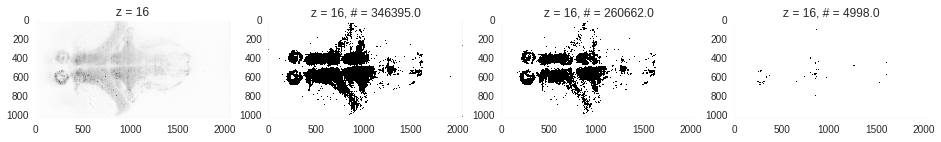

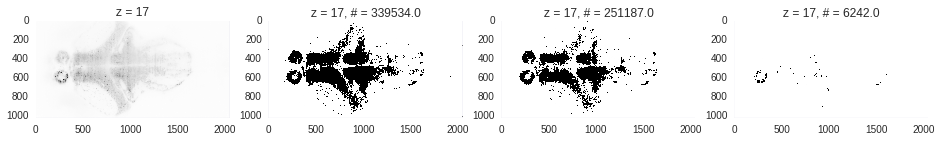

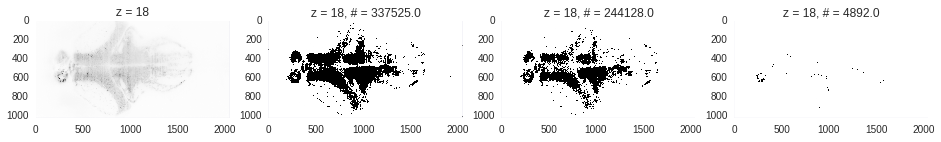

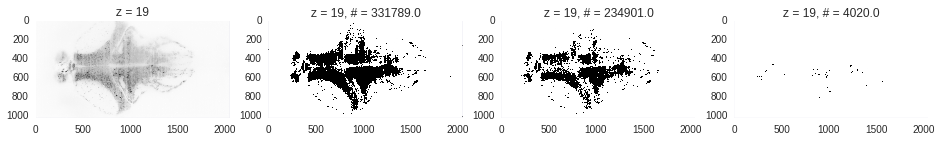

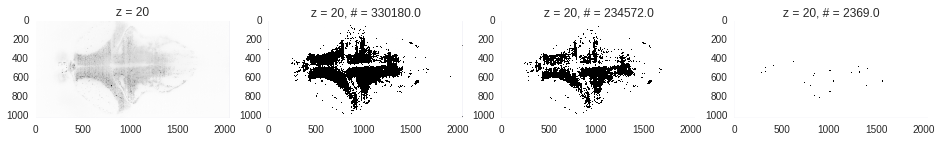

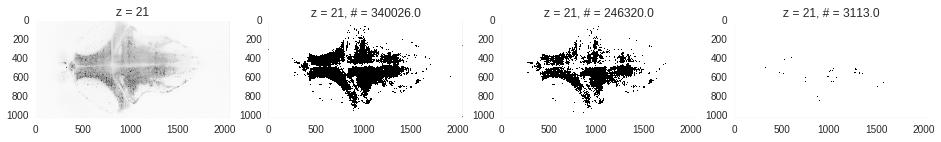

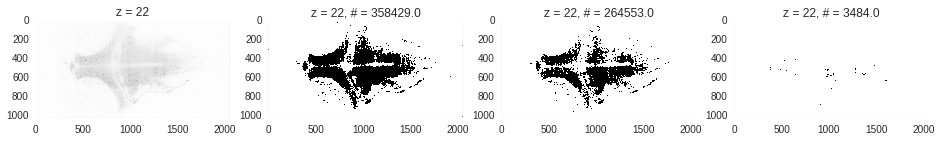

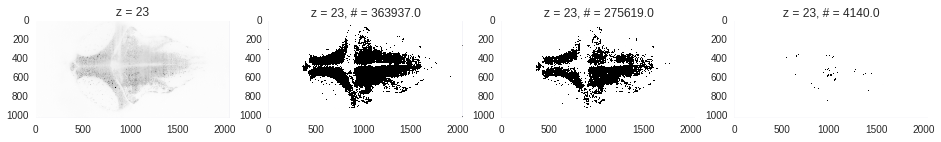

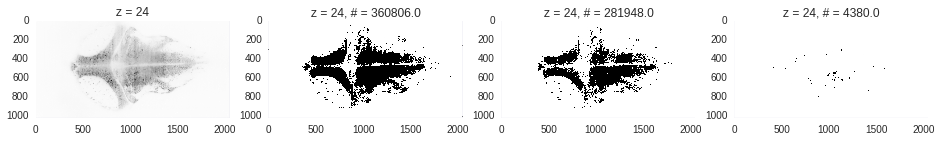

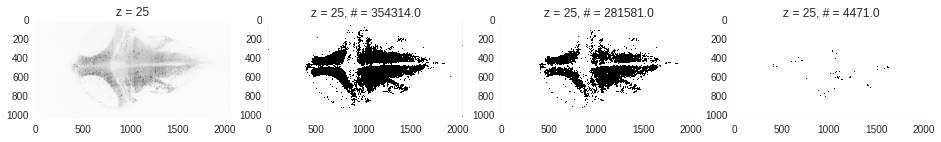

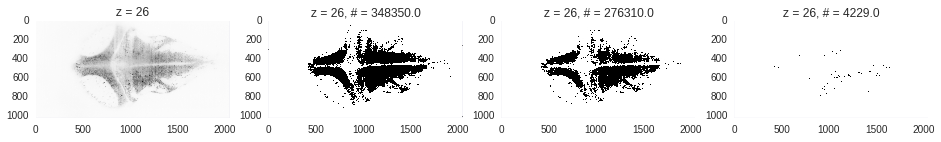

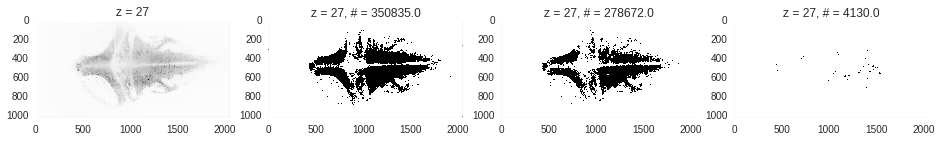

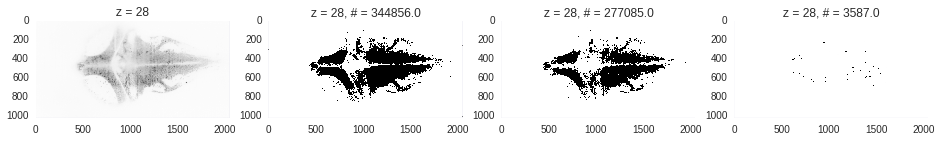

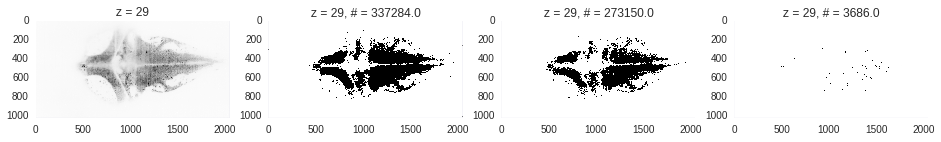

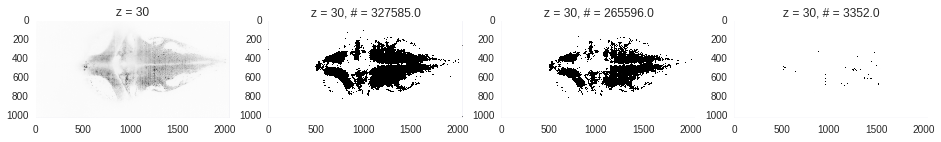

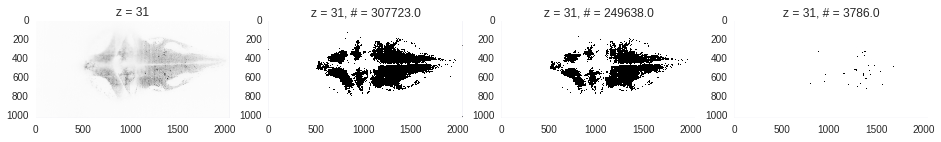

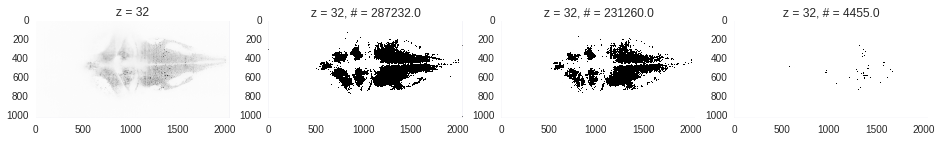

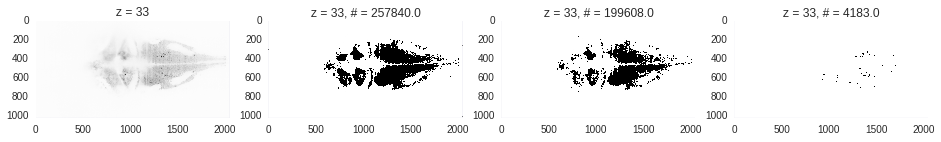

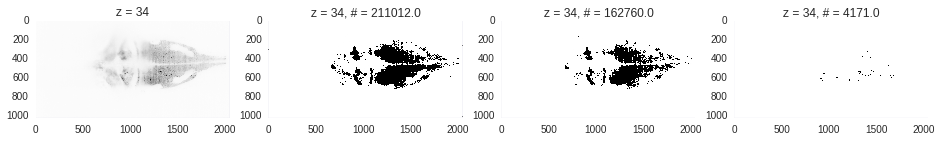

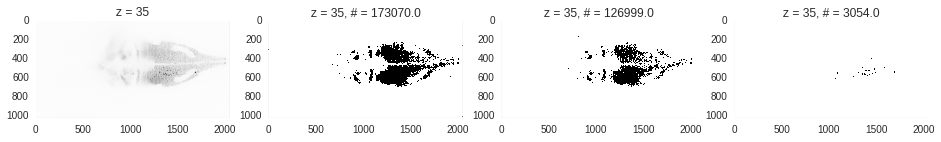

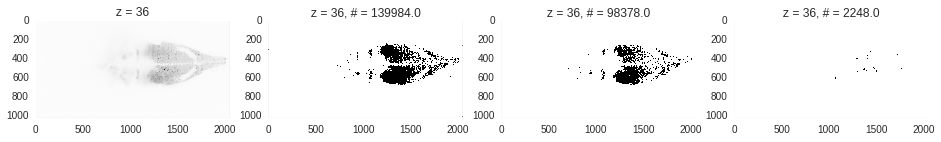

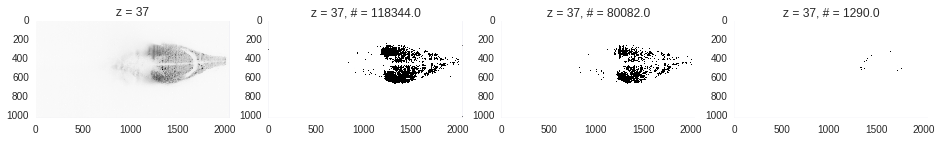

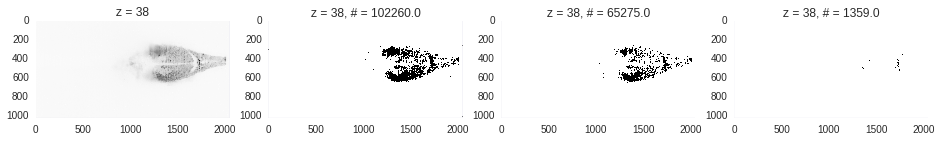

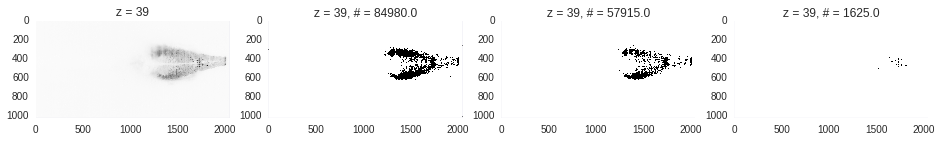

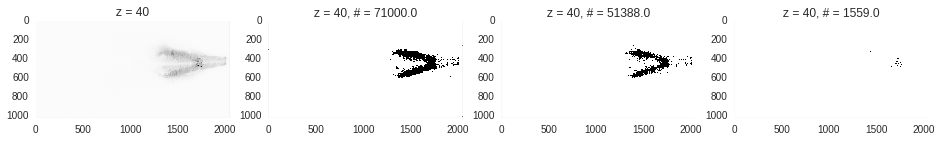

10430256.0
7828017.0
160495.0


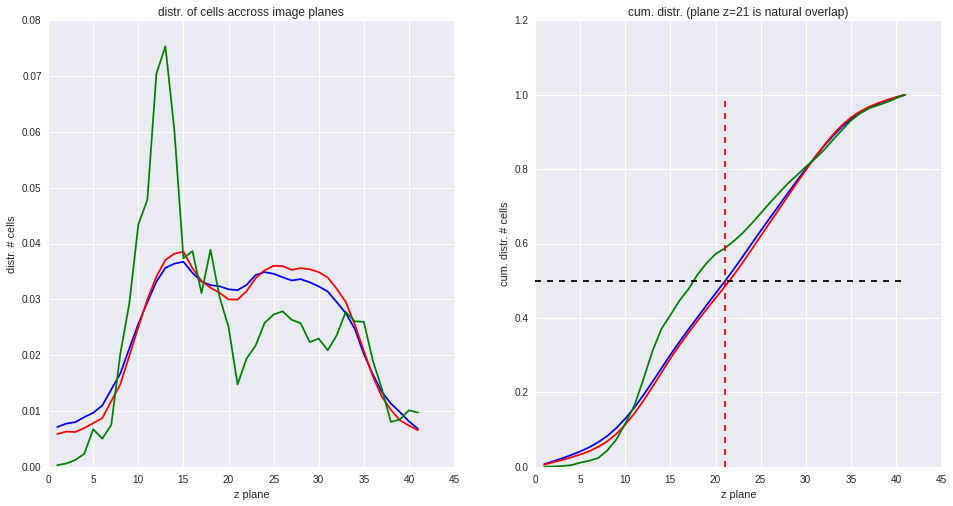

In [3]:
nx, ny, nz = 41, 1024, 2048
p_full = nx * ny * nz

idx_occ = np.zeros(p_full, dtype=bool)
idx_occ[idx_large] = True
occ_large = idx_occ.reshape(nx,ny,nz).copy()

idx_occ = np.zeros(p_full, dtype=bool)
idx_occ[idx_medium] = True
occ_medium = idx_occ.reshape(nx,ny,nz).copy()

idx_occ = np.zeros(p_full, dtype=bool)
idx_occ[idx_small] = True
occ_small = idx_occ.reshape(nx,ny,nz).copy()

rel_dens_large = np.zeros((nx))
rel_dens_medium = np.zeros((nx))
rel_dens_small = np.zeros((nx))

for i in range(nx):
    plt.figure(figsize=(16, 4))
    plt.subplot(1,4,1)
    plt.imshow(y_means[i,:,:], interpolation='None')
    plt.grid('off')
    plt.title('z = ' + str(i))
    plt.subplot(1,4,2)
    plt.imshow(occ_large[i,:,:], interpolation='None')
    plt.grid('off')
    rel_dens_large[i] = occ_large[i,:,:].sum()
    if i == 0:
        plt.title('large idx set, # = ' + str(rel_dens_large[i]))
    else:
        plt.title('z = ' + str(i) + ', # = ' + str(rel_dens_large[i]))
    plt.subplot(1,4,3)
    plt.imshow(occ_medium[i,:,:], interpolation='None')
    rel_dens_medium[i] = occ_medium[i,:,:].sum()
    if i == 0:
        plt.title('medium idx set, # = ' + str(rel_dens_medium[i]))
    else:
        plt.title('z = ' + str(i) + ', # = ' + str(rel_dens_medium[i]))
    plt.grid('off')
    plt.subplot(1,4,4)
    plt.imshow(occ_small[i,:,:], interpolation='None')
    rel_dens_small[i] = occ_small[i,:,:].sum()
    if i == 0:
        plt.title('small idx set, # = ' + str(rel_dens_small[i]))
    else:
        plt.title('z = ' + str(i) + ', # = ' + str(rel_dens_small[i]))
    plt.grid('off')
    plt.show()

print(rel_dens_large.sum())    
print(rel_dens_medium.sum())    
print(rel_dens_small.sum())    
rel_dens_large /= rel_dens_large.sum()
rel_dens_medium /= rel_dens_medium.sum()
rel_dens_small /= rel_dens_small.sum()

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.plot(np.arange(nx)+1, rel_dens_large, 'b')
plt.hold('on')
plt.plot(np.arange(nx)+1, rel_dens_medium, 'r')
plt.plot(np.arange(nx)+1, rel_dens_small, 'g')
plt.title('distr. of cells accross image planes')
plt.xlabel('z plane')
plt.ylabel('distr. # cells')

plt.subplot(1,2,2)
plt.plot(np.arange(nx)+1, np.cumsum(rel_dens_large), 'b')
plt.hold('on')
plt.plot(np.arange(nx)+1, np.cumsum(rel_dens_medium), 'r')
plt.plot(np.arange(nx)+1, np.cumsum(rel_dens_small), 'g')
plt.plot((0, nx), [0.5, 0.5], 'k--')
plt.plot((21, 21), [0, 1], 'r--')
plt.xlabel('z plane')
plt.ylabel('cum. distr. # cells')
plt.title('cum. distr. (plane z=21 is natural overlap)')
plt.show()


In [ ]:
np.save(data_path + 'idx_large', idx_large)
np.save(data_path + 'idx_medium', idx_medium)
np.save(data_path + 'idx_small', idx_small)
